In [117]:
import matplotlib.pyplot as plt
import numpy as np
import numpy_financial as npf
import graphs
import scipy.integrate as integrate
import scipy.optimize as opt
import palettable

In [3]:
def inv(x):
    return np.divide(1, x)

def wright(x, b):
    return np.power(x, np.log2(1-b))

x = np.linspace(1, 100, 250)

y = inv(x)
w = wright(x, 0.15)

Text(0.5, 0, 'Cumulative units produced')

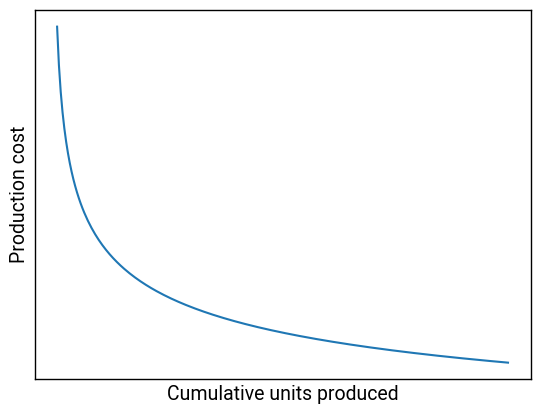

In [4]:
fig, ax = plt.subplots(1,1)

ax.plot(x, w)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_xticks([])

ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.set_yticks([])
ax.set_ylabel("Production cost")
ax.set_xlabel("Cumulative units produced")


In [30]:
H2_HHV = 39.4 # kWh/kg
efficiency = 0.80


electricity_price = 0.030 #$/kWh

electricity_consumption_per_kg = H2_HHV/efficiency
electricity_cost_per_kg = electricity_consumption_per_kg * electricity_price

In [31]:
print(electricity_consumption_per_kg)
print(electricity_cost_per_kg)

49.24999999999999
1.4774999999999998


In [56]:
discount_rate = 0.10
project_life = 20 #years
capacity_factor = 0.90
hours_per_year = 8760*capacity_factor

def CAPEX_per_kg(CAPEX, discount = discount_rate):
    consumption = H2_HHV/efficiency
    CAPEX_per_capacity = CAPEX*consumption/hours_per_year
    return -npf.pmt(discount, project_life, CAPEX_per_capacity)

def OPEX_per_kg(CAPEX, percent = 0.04):
    consumption = H2_HHV/efficiency
    CAPEX_per_capacity = CAPEX*consumption/hours_per_year
    return CAPEX_per_capacity*percent

In [57]:
def total_per_kg(CAPEX, discount=discount_rate, percent =0.04):
    CAPEX_contribution = CAPEX_per_kg(CAPEX, discount)
    OPEX_contribution = OPEX_per_kg(CAPEX, percent)
    
    return CAPEX_contribution + OPEX_contribution + electricity_cost_per_kg

In [58]:
print(CAPEX_per_kg(2500))
print(total_per_kg(2500))

1.8343754820040203
3.936558384084183


In [60]:
cost_target = 2.00
capex_for_cost_target = opt.brentq(lambda capex: cost_target-total_per_kg(capex), 0, 2500)
print(capex_for_cost_target)

531.1992624715504


In [93]:
total_H2_production = 100000000 #tons per year
electrolyzer_production_per_kW = hours_per_year/(H2_HHV/efficiency)/1000 #tons per year
total_electrolyzer_capacity = total_H2_production/electrolyzer_production_per_kW #kW

current_PEM_capacity = 300*1000 #kW
current_CAPEX = 2500.0 #$/kW

def final_cost(learning_rate, final_count, initial_count, initial_cost = current_CAPEX):
    x = final_count/initial_count
    return np.pow(x, np.log2(1.0-learning_rate))*initial_cost

def cumulative_cost(learning_rate, final_count, initial_count, initial_cost = current_CAPEX):
    f = lambda x: final_cost(learning_rate, x, initial_count, initial_cost)
    cum = integrate.quad(f, initial_count, final_count)
    return cum[0]

def count_to_reach_cost_target(learning_rate, initial_count, target = capex_for_cost_target, initial_cost = current_CAPEX):
    f = lambda final: target - final_cost(learning_rate, final, initial_count, initial_cost)
    try:
        val = opt.brentq(f, initial_count, total_electrolyzer_capacity*1e6)
        return val
    except ValueError:
        print(f"Warning: f(a) and f(b) do not have different signs for learning rate {learning_rate}.")
        print(f"f(a) = {f(initial_count)}, f(b) = {f(total_electrolyzer_capacity*1e6)}")
        return -1
    

In [94]:
print(f'{total_electrolyzer_capacity:,.0f}')
print(f"{final_cost(0.15, total_electrolyzer_capacity, current_PEM_capacity):.0f}")
print(f"${round(cumulative_cost(0.15, total_electrolyzer_capacity, current_PEM_capacity),-9):,}")
print(f"{count_to_reach_cost_target(0.15, current_PEM_capacity):,.0f}")

624,682,902
417
$339,000,000,000.0
221,885,358


In [95]:
cost_target = 2.00 #$/kg


In [106]:
learning_rates = np.linspace(0.05, 0.20)

final_capex = final_cost(learning_rates, total_electrolyzer_capacity, current_PEM_capacity)
production_costs = total_per_kg(final_capex)

cum_costs = []
cum_before_profit = []
for rate in learning_rates:
    cum_costs.append( cumulative_cost(rate, total_electrolyzer_capacity, current_PEM_capacity)/1e9)
    installed_capacity_for_breakeven = count_to_reach_cost_target(rate, current_PEM_capacity)
    cum_before_profit.append(cumulative_cost(rate, installed_capacity_for_breakeven, current_PEM_capacity)/1e9)

In [153]:
production_costs

array([2.87449571, 2.82566409, 2.77838948, 2.73262705, 2.68833312,
       2.64546512, 2.60398159, 2.56384216, 2.52500749, 2.48743927,
       2.4511002 , 2.41595396, 2.38196519, 2.34909945, 2.31732324,
       2.28660392, 2.25690974, 2.22820981, 2.20047405, 2.17367321,
       2.14777882, 2.12276318, 2.09859937, 2.07526117, 2.0527231 ,
       2.03096039, 2.00994894, 1.98966532, 1.97008675, 1.9511911 ,
       1.93295685, 1.91536308, 1.89838946, 1.88201626, 1.86622428,
       1.85099487, 1.83630995, 1.82215191, 1.80850367, 1.79534866,
       1.78267077, 1.77045436, 1.75868425, 1.74734572, 1.73642446,
       1.7259066 , 1.71577868, 1.70602763, 1.69664077, 1.68760583])

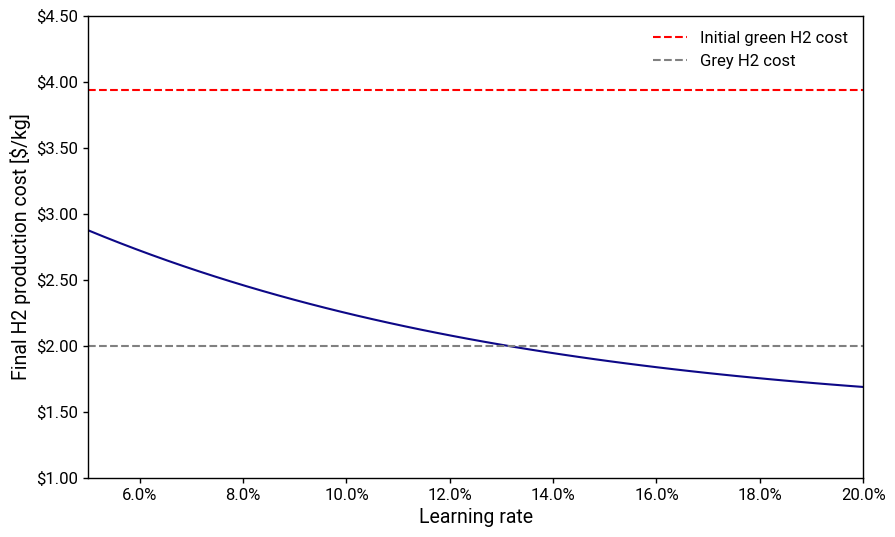

In [152]:
from matplotlib import ticker
from cycler import cycler

plasma_cycler = cycler(color=palettable.matplotlib.Plasma_3.mpl_colors)
plt.rc('axes', prop_cycle=plasma_cycler)

fig, (ax2) = plt.subplots(1,1)
fig.set_size_inches(10,6)


ax2.set_xlabel("Learning rate")
ax2.plot(learning_rates, production_costs)
ax2.set_ylabel("Final H2 production cost [$/kg]")
ax2.axhline(total_per_kg(current_CAPEX), linestyle="--", color="red", label="Initial green H2 cost")
ax2.axhline(cost_target, linestyle="--", color="grey", label="Grey H2 cost")
ax2.xaxis.set_major_formatter(ticker.PercentFormatter(1.0))
ax2.set_xlim(0.05, 0.20)
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%.2f'))
ax2.set_ylim(1.0, 4.50)
ax2.legend(fontsize=12)

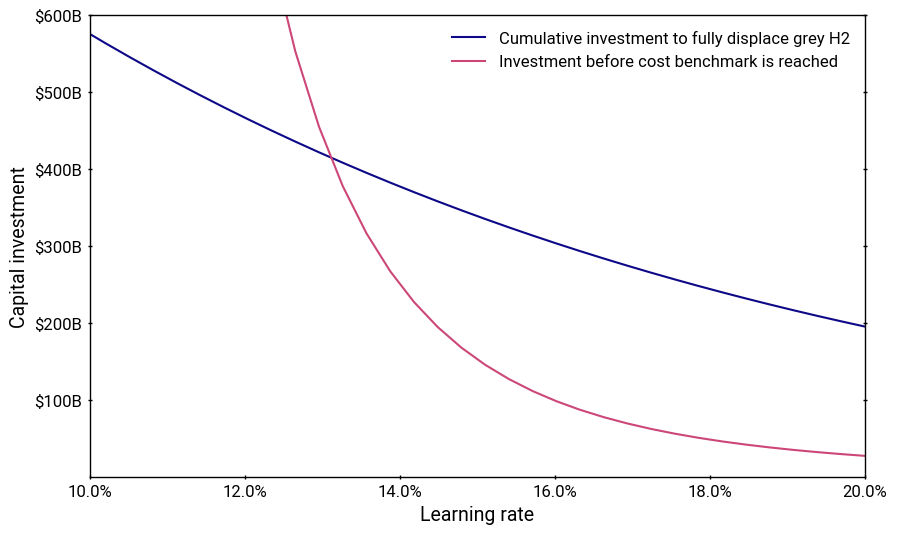

In [149]:
fig, (ax1) = plt.subplots(1,1)
fig.set_size_inches(10,6)

ax1.plot(learning_rates, cum_costs,  label="Cumulative investment to fully displace grey H2")
ax1.set_ylabel("Capital investment")
ax1.plot(learning_rates, cum_before_profit,label="Investment before cost benchmark is reached")
ax1.set_xlabel("Learning rate")
ax1.set_xlim(0.10, 0.20)
ax1.set_ylim(0.1, 600)
ax1.tick_params(left=True, right=True, direction='inout')
ax1.xaxis.set_major_formatter(ticker.PercentFormatter(1.0))
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%.0fB'))

ax1.legend(fontsize=12)


In [266]:
import scipy.stats as stats
# calculate cost distribution with price arbitrage
average_cost = 0.050 #$/kWh
alpha = np.emath.logn(4,5)

scale = (alpha-1)*average_cost/alpha #calculated from pdf mean
print(alpha)
print(scale)

capacity_factor = 0.80
CFs = np.linspace(0.00, 0.999, 250)

x = np.linspace(stats.pareto.ppf(0.01, alpha, scale=scale),stats.pareto.ppf(0.99, alpha, scale=scale), 250)

average_price = lambda CF: stats.pareto.sf(stats.pareto.ppf(1-CF, alpha, scale=scale), alpha, scale=scale)
xs = stats.pareto.isf(1-CFs, alpha, scale=scale)
vals = stats.pareto.pdf(x, alpha, scale=scale)
cvals = stats.pareto.sf(np.flip(x), alpha, scale=scale)


1.160964047443681
0.006932344192660692


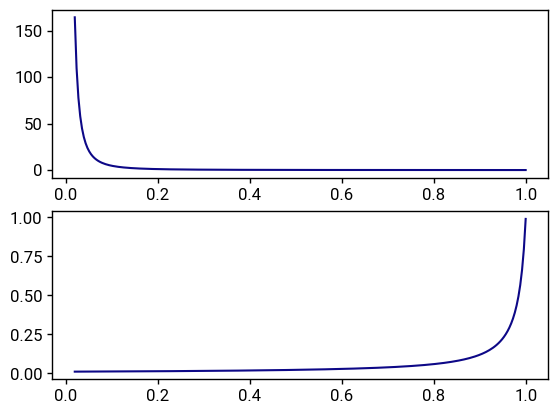

In [267]:
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(x/np.max(x), vals)
ax2.plot(x/np.max(x), cvals)

In [ ]:

fig, ax = plt.subplots(1,1)
ax.plot(x/np.max(x), vals)

av

0.007590903570527073
